In [76]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# グラフ描画
from matplotlib import pyplot as plt
# 標準化
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [77]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

In [78]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [79]:
# 性別を変換する（訓練データ）
gemder=pd.get_dummies(df_train.loc[:,['Gender']])
df_train['Female']=gemder.loc[:,['Gender_Female']]
df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Female,Male
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,0,1
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,0,1
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,0,1
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,0,1
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,1,0


In [80]:
tain_col_colname=df_train.columns.values

In [81]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [82]:
# 性別を変換する（評価データ）
gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
df_vat['Female']=gemder.loc[:,['Gender_Female']]
df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Female,Male
0,25,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006,0,1
1,26,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562,1,0
2,64,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579,0,1
3,65,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070,0,1
4,34,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078,1,0


In [83]:
# 説明変数（訓練データ）
x_train = np.array(df_train.loc[:,['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio', 'Female', 'Male']])
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])
# 説明変数（訓練データ）
x_vat = np.array(df_vat)

In [84]:
y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
y[np.arange(len(y_train)), y_train.T] = 1
y_train = y
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.20, random_state=1) 

In [85]:
#sc = StandardScaler() 
norm = MinMaxScaler()
X_train=norm.fit_transform(X_train)
X_test=norm.transform(X_test)
X_vat=norm.transform(x_vat)

In [86]:
df_train = pd.DataFrame(X_train, columns=['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio', 'Female', 'Male'])
df_train.describe()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Female,Male
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,0.534905,0.045186,0.031156,0.058217,0.023745,0.059021,0.563957,0.474299,0.436378,0.188235,0.811765
std,0.242825,0.107321,0.085852,0.108265,0.095030,0.130112,0.214871,0.198614,0.190352,0.391188,0.391188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.323529,0.008669,0.006229,0.026103,0.005712,0.012316,0.489672,0.338552,0.316594,0.000000,1.000000
50%,0.558824,0.010980,0.008883,0.029352,0.008030,0.020005,0.530462,0.509008,0.485942,0.000000,1.000000
75%,0.750000,0.025006,0.016488,0.034027,0.012593,0.055500,0.690686,0.544787,0.553694,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [87]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(x_vat).float()

In [88]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)

torch.Size([680, 11])


In [89]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([680, 2])

In [90]:
# x と y の値をひとつの変数に格納する
train = TensorDataset(X_train ,Y_train)

In [97]:
# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
train_loader = DataLoader(train ,batch_size=5, shuffle=True)

In [98]:
node1=10
# node2=20


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
#        self.fc2 = nn.Linear(node1 , node2)             # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        y = F.sigmoid(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
        y = F.sigmoid(self.fc2(y))              # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
#        y = self.fc2(y)                         # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        #return F.log_softmax(y , dim=0)
        return y

In [99]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
# criterion = nn.MSELoss()
# 損失の定義 (交差エントロピー誤差関数)
# criterion = nn.CrossEntropyLoss()
# 損失の定義 (エントロピー誤差関数)
criterion = nn.BCELoss()

In [100]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
# optimizer = optim.Adam(model.parameters() , lr=0.01)
optimizer = optim.SGD(model.parameters() , lr=0.01)

In [101]:
loss_list = []
loss_temp = 0
# トレーニングの回数分ループする。
for epoch in range(300):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        
        #print('epoch', epoch+1)
        #print('output',output)
        #print('y_train',y_train)
        
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%100 == 0:
        loss_list.append(loss.item()/(10*len(train_loader)))
        print(f'Epoch {epoch+1} Loss {loss.item()/(10*len(train_loader))} -- {loss_temp}')
        loss_temp = 0

Epoch 100 Loss 0.0005431950968854568 -- 9273.46875
Epoch 200 Loss 0.00040710905895513646 -- 8869.9248046875
Epoch 300 Loss 0.0003739637925344355 -- 8062.36865234375


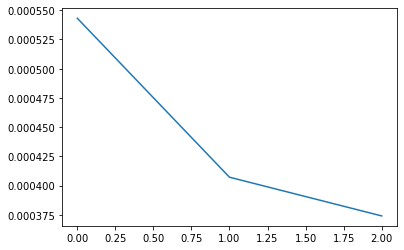

In [102]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [103]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x).data ,1)[1]
y_true = torch.max(y ,1)[1]
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
print(accuracy)
print(y_hat.numpy())
print(y_true.data.numpy())

0.7411764705882353
[0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0]


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

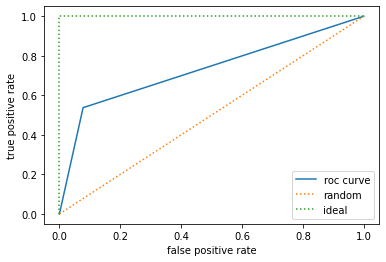

[2 1 0]


In [104]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [105]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.7298611111111113


#  予測する

In [ ]:
y_predict = torch.max(model(X_vat).data ,1)[1]
df_out = pd.DataFrame(np.array(np.round(y_predict.detach().numpy().copy()),dtype=np.int64), columns=['val'])
               
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


# モデルの保存

In [ ]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)